# Spike Detection Analysis


## Import Libraries


In [32]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.signal
import IPython.display as ipd
import matplotlib.colors as mcolors
from scipy.io import wavfile
from scipy.signal import lfilter, butter
from collections import deque
import sys
from sklearn.decomposition import PCA

plt.style.use("ggplot")

## Function Definitions


In [3]:
def identify_potential_initial_spikes(amplitude_array, return_local_maximum=True):
    """This function searches for peak amplitudes that may be initial
    neural spiking activity. This function is extended to filter the
    local maximum or minimum spiking activity. This is used to identify
    second or third spikes as well.

    Args:
        amplitude_array (numpy.ndarray): This contains an array of
                                         amplitudes of neural signal.
        return_local_maximum (bool, optional): This defines the logic of
                                               the returned values. If
                                               True, the values will be
                                               the local maximums of the
                                               amplitude array. When
                                               False, the returned list
                                               will be local minimums.

    Returns:
        list: This is a list of boolean values that indicate whether a
        point is a local maximum with respect to the next and previous
        amplitudes. If return_local_maximum is set to False, then the
        returned list contains information of local minimums instead.
    """
    if len(amplitude_array) < 3:
        if len(amplitude_array) == 0:
            return ValueError("Length of amplitude array must be greater than 0")
        elif len(amplitude_array) == 1:
            return [True]
        else:
            if return_local_maximum:
                if amplitude_array[0] < amplitude_array[1]:
                    return [False, True]
                else:
                    return [True, False]
            else:
                if amplitude_array[0] < amplitude_array[1]:
                    return [True, False]
                else:
                    return [False, True]
    else:
        if return_local_maximum:
            local_maximum_list = []
            for idx, val in enumerate(amplitude_array[0:-1]):
                if idx == 0:
                    if amplitude_array[idx + 1] < val:
                        local_maximum_list.append(True)
                    else:
                        local_maximum_list.append(False)
                    continue
                if (amplitude_array[idx - 1] < val) and (
                    val > amplitude_array[idx + 1]
                ):
                    local_maximum_list.append(True)
                else:
                    local_maximum_list.append(False)
            if amplitude_array[-1] > amplitude_array[-2]:
                local_maximum_list.append(True)
            else:
                local_maximum_list.append(False)
            return local_maximum_list
        else:
            local_minimum_list = []
            for idx, val in enumerate(amplitude_array[0:-1]):
                if idx == 0:
                    if amplitude_array[idx + 1] > val:
                        local_minimum_list.append(True)
                    else:
                        local_minimum_list.append(False)
                    continue
                if (amplitude_array[idx - 1] > val) and (
                    val < amplitude_array[idx + 1]
                ):
                    local_minimum_list.append(True)
                else:
                    local_minimum_list.append(False)
            if amplitude_array[-1] < amplitude_array[-2]:
                local_minimum_list.append(True)
            else:
                local_minimum_list.append(False)
            return local_minimum_list

In [4]:
def estimate_noise_floor(amplitude_array, window_size=10):
    """This function will estimate the noise floor. The amplitude array
    must be at least of length of the window size or a single value.

    Args:
        amplitude_array (numpy.ndarray): Array of amplitudes with which
                                         to derive the noise floor.

        window_size (int, optional): This is the width of the window
                                     used to calculate a rolling median
                                     average.

    Return:
        noise_floor_estimate (np.ndarray): This is the estimate of the
                                           noise floor.
    """
    if len(amplitude_array) == 0:
        raise ValueError("Length of amplitude array must be greater than 0")
    elif len(amplitude_array) == 1:
        noise_floor_estimate = np.array(
            [np.sqrt(np.abs(np.float64(amplitude_array[0])) ** 2)]
        )
        return noise_floor_estimate
    else:
        if len(amplitude_array) < window_size:
            window_size = len(amplitude_array)
        power_of_filtered_data = np.abs(np.float64(amplitude_array) ** 2)

        rolling_median_array = []
        for index in range(0, len(power_of_filtered_data), 1):
            current_median = np.median(
                power_of_filtered_data[index : index + window_size]
            )
            rolling_median_array.append(current_median)

        rolling_median_array = np.array(rolling_median_array)

        noise_floor_estimate = np.sqrt(rolling_median_array)

        return noise_floor_estimate

In [5]:
def detect_neural_spikes(t, neural_data):
    """This function detects spikes in real-time.
    It returns an array of spikes at specific times and amplitudes with
    zeroed out noise.

    Args:
        t (array): This is the array of values that indicate the time of
                   each point in the neural_data array.
        neural_data (array): This is the array of amplitudes for each
                             point of time of the neural data.

    Returns:
        (list): This is the array inclusive of amplitudes of spikes at
                each specific point in the initial time array. Non-spike
                points have been replaced with amplitudes of zero value.
    """
    noise_floor_window = 5
    initial_first_point_of_spike_detected = False
    second_point_of_spike_detected = False
    third_point_of_spike_detected = False
    spike_train_time_index_list = []

    for current_time_index, time in enumerate(t):
        # Estimate the noise floor
        if current_time_index < noise_floor_window:
            current_noise_floor_estimate_list = estimate_noise_floor(
                [neural_data[current_time_index]]
            )
        else:
            current_noise_floor_estimate_list = estimate_noise_floor(
                neural_data[
                    current_time_index - noise_floor_window : current_time_index
                ],
                window_size=noise_floor_window,
            )

        current_noise_floor_estimate = current_noise_floor_estimate_list[0]
        current_noise_floor_estimate_inverse = -(current_noise_floor_estimate)

        # Detect Initial First Point
        if initial_first_point_of_spike_detected == False:
            if current_time_index == 0:
                local_maximum_list_of_current_time_index = (
                    identify_potential_initial_spikes(
                        neural_data[current_time_index : current_time_index + 1]
                    )
                )
                is_current_time_index_local_maximum = (
                    local_maximum_list_of_current_time_index[0]
                )
            else:
                local_maximum_list_of_current_time_index = (
                    identify_potential_initial_spikes(
                        neural_data[current_time_index - 1 : current_time_index + 2]
                    )
                )
                is_current_time_index_local_maximum = (
                    local_maximum_list_of_current_time_index[1]
                )

            if is_current_time_index_local_maximum == True:
                # First Point Potentially Identified
                initial_first_point_of_spike_detected = True
                spike_time_index_first_point = current_time_index
        elif (
            second_point_of_spike_detected == False
            and initial_first_point_of_spike_detected == True
        ):
            # Detect Second Point
            local_minimum_list_of_current_time_index = (
                identify_potential_initial_spikes(
                    neural_data[current_time_index - 1 : current_time_index + 2],
                    return_local_maximum=False,
                )
            )
            is_current_time_index_local_minimum = (
                local_minimum_list_of_current_time_index[1]
            )
            if is_current_time_index_local_minimum == True:
                if (
                    neural_data[current_time_index]
                    < current_noise_floor_estimate_inverse
                ):
                    # Second Point Found
                    spike_time_index_list_first_to_second_points = np.arange(
                        start=spike_time_index_first_point,
                        stop=current_time_index,
                        step=1,
                    )
                    spike_time_index_second_point = current_time_index
                    second_point_of_spike_detected = True
                else:
                    initial_first_point_of_spike_detected = False
        elif (
            initial_first_point_of_spike_detected == True
            and second_point_of_spike_detected == True
            and third_point_of_spike_detected == False
        ):
            # Detect Third Point
            local_maximum_list_of_current_time_index = (
                identify_potential_initial_spikes(
                    neural_data[current_time_index - 1 : current_time_index + 2]
                )
            )
            is_current_time_index_local_maximum = (
                local_maximum_list_of_current_time_index[1]
            )
            if is_current_time_index_local_maximum == True:
                if neural_data[current_time_index] > current_noise_floor_estimate:
                    # Third Point Found
                    spike_time_index_list_second_to_third_points = np.arange(
                        spike_time_index_second_point,
                        current_time_index,
                        step=1,
                    )
                    third_point_of_spike_detected = True
                    time_index_of_most_recent_third_spike = current_time_index
                else:
                    initial_first_point_of_spike_detected = True
                    second_point_of_spike_detected = False
                    spike_time_index_first_point = current_time_index
        elif (
            initial_first_point_of_spike_detected == True
            and second_point_of_spike_detected == True
            and third_point_of_spike_detected == True
        ):
            # Detect Fourth Point
            if neural_data[current_time_index] < 0:
                time_index_of_most_recent_fourth_spike_point = current_time_index
                spike_time_index_list_third_to_fourth_points = np.arange(
                    time_index_of_most_recent_third_spike,
                    time_index_of_most_recent_fourth_spike_point
                    + 1,  # include the fourth detected point
                    step=1,
                )
                spike_time_index_list = np.concatenate(
                    [
                        spike_time_index_list_first_to_second_points,
                        spike_time_index_list_second_to_third_points,
                        spike_time_index_list_third_to_fourth_points,
                    ]
                )
                spike_train_time_index_list.append(spike_time_index_list)

                initial_first_point_of_spike_detected = False
                second_point_of_spike_detected = False
                third_point_of_spike_detected = False
        else:
            raise ValueError("Error in Spike Detection State")

    return spike_train_time_index_list

In [6]:
def create_encoded_data(
    sample_rate,
    number_of_samples,
    spike_train_time_index_list,
    neural_data,
):
    """This function creates an encoded version of the initial data.

    Args:
        spike_train_time_index_list (list): This is the list of array of
                                            floats that indicate indices
                                            of amplitudes.
        neural_data (array): These are the amplitudes of all values in
                             the dataset.
        time_array_of_neural_data (array): These are the points of time
                                           of the dataset.
        sample_rate (int): This is the sample rate of the data. The
                              samples are equidistant depending upon the
                              sampling frequency as calculated from the
                              inverse of the sample rate.
        number_of_samples (int): This is the total number of samples in
                                 the dataset.

    Returns:
        encoded_data (list): This is the encoded data. This encoded data
                             has the sample rate, the number of samples,
                             the initial start time index of the first
                             amplitude, and the information of the
                             amplitudes of the detected eeg spikes.
                             This pattern of the initial time index
                             of the first amplitude, represented as an
                             int, followed by the array of amplitude
                             values at each sample is repeated for each
                             detected spike. It is implied that the
                             samples are equidistant depending upon
                             the sampling frequency as calculated from
                             the inverse of the sample rate, that the
                             length of time of the entire data is
                             inferred from the number of samples divided
                             by the sample rate, and all amplitudes at
                             samples not explicitly defined are to be
                             considered noise and are therefore set to
                             zero to reduce size while retaining
                             information. The time of each amplitude is
                             calculated as the division of the starting
                             time index plus the current position of
                             each amplitude by the current posigion in
                             the zero-based amplitude array by the
                             sample rate.
    """
    encoded_data = []
    encoded_data.append(sample_rate)
    encoded_data.append(number_of_samples)
    for spike_train_index in range(0, len(spike_train_time_index_list)):
        index = np.int16(spike_train_time_index_list[spike_train_index][0])
        if index < 0:
            print(index)
        encoded_data.append(np.int64(spike_train_time_index_list[spike_train_index][0]))
        encoded_data.append(neural_data[spike_train_time_index_list[spike_train_index]])

    return encoded_data

## Load Data


In [7]:
data_dir = "../data/"
data_file_list = glob(data_dir + "*.wav")
current_data_file = data_file_list[0]

In [8]:
ipd.Audio(current_data_file)

In [9]:
sample_rate, raw_neural_data = wavfile.read(current_data_file)
time_array_length = len(raw_neural_data) / sample_rate
time_array = np.arange(start=0, stop=time_array_length, step=(1 / sample_rate))

#### Pandas Implementation of Graphing


In [10]:
import pandas as pd

In [11]:
raw_neural_data_df = pd.DataFrame(raw_neural_data, columns=["Amplitude"])

In [12]:
raw_neural_data_df.set_index(time_array, inplace=True)
raw_neural_data_df.index.name = "Time [s]"

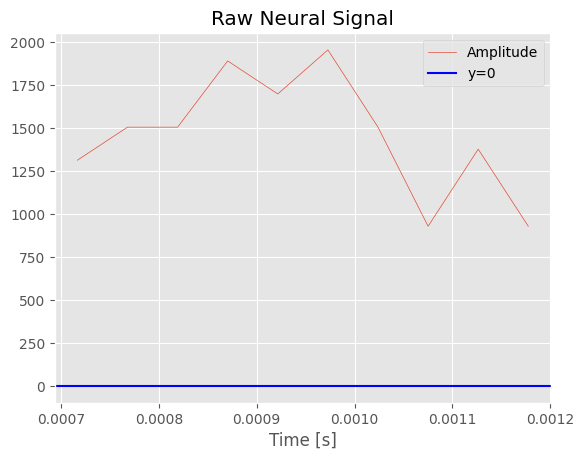

In [13]:
WINDOW_SCALE = 0.1
WINDOW_START = 100
WINDOW_SIZE = 100
WINDOW_SHIFT = 40

raw_neural_data_df.iloc[
    int(WINDOW_SCALE * (WINDOW_START + WINDOW_SHIFT)) : int(
        WINDOW_SCALE * (WINDOW_START + WINDOW_SIZE + WINDOW_SHIFT)
    )
].plot(linewidth=0.5)
plt.axhline(y=0, color="blue", label="y=0")
plt.title("Raw Neural Signal")
plt.legend()
plt.show()

#### Plot of Raw Neural Data


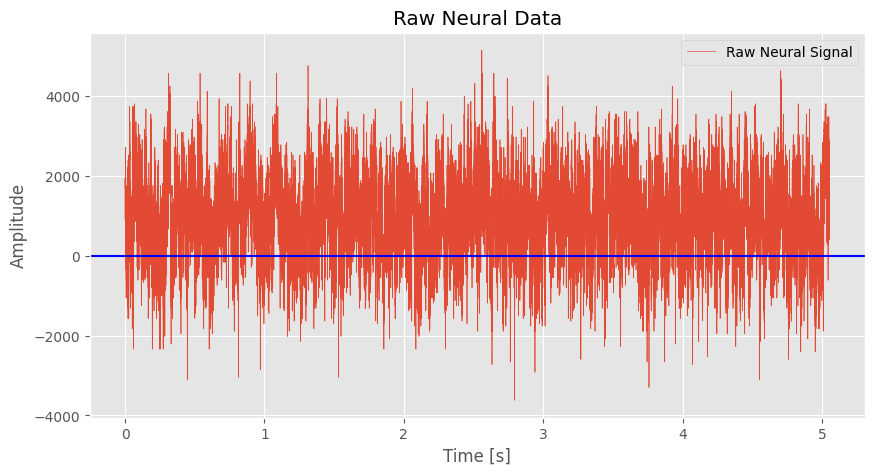

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(time_array, raw_neural_data, linewidth=0.5)
plt.title("Raw Neural Data")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(["Raw Neural Signal"])
plt.grid(True)
plt.axhline(y=0, color="blue")
plt.show()

In [15]:
raw_neural_data

array([1697, 1889, 1569, ...,  928, 1184, 1504], dtype=int16)

## Preprocess the Signal


### Example Noise Removal

In [64]:
# Estimate the power spectral density using welch
from scipy.signal import welch
from scipy.signal import butter, filtfilt

In [66]:
# Creating a sample signal with noise
fs = 1000 # Sampling rate in Hz
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 10 * t) # 10 Hz sample signal
noise = np.random.normal(0, 0.5, fs) # Gaussian noise
data = signal + noise

In [67]:
# Compute power spectral density
f, Pxx = welch(data, fs, nperseg=256)

In [74]:
# Creating a low-pass filter to filter the noise of the signal
# Define a low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq  # Normalize cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # Butterworth filter
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)  # Get filter coefficients
    y = filtfilt(b, a, data)  # Apply filter to the data
    return y

# Set the cutoff frequency
cutoff = 100  # Cutoff frequency in Hz (adjust based on your signal characteristics)

# Apply the low-pass filter
filtered_data = lowpass_filter(data, cutoff, fs)

# Compute power spectral density of the filtered signal
filterd_data_f, filtered_data_Pxx = welch(filtered_data, fs, nperseg=256)

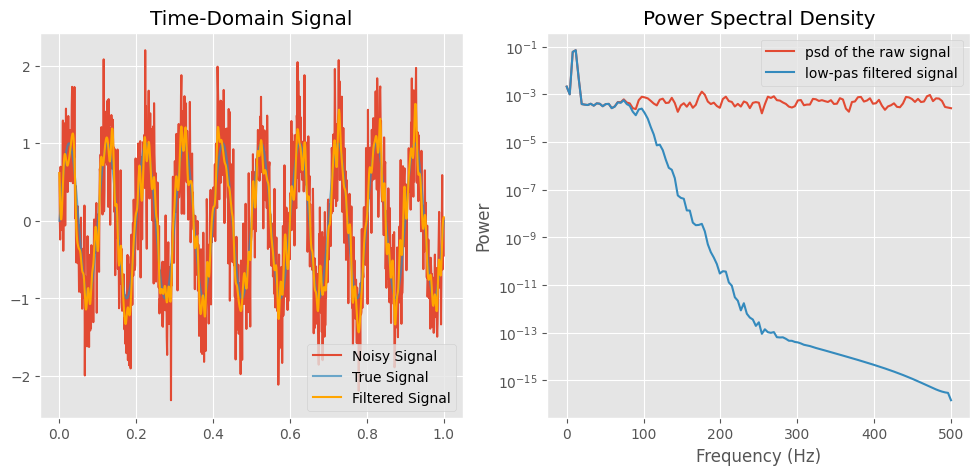

In [75]:
# Plot the time domain 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(t, data, label="Noisy Signal")
plt.plot(t, signal, label="True Signal", alpha=0.7)
plt.plot(t, filtered_data, label="Filtered Signal", color='orange')
plt.legend()
plt.title("Time-Domain Signal")

# Plot frequency spectrum
plt.subplot(1,2,2)
plt.semilogy(f, Pxx, label='psd of the raw signal')
plt.semilogy(filterd_data_f, filtered_data_Pxx, label='low-pas filtered signal')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectral Density")
plt.legend()

# plt.subplot(1, 3, 3)
# plt.title("Filtered Signal (Low-Pass)")
# plt.xlabel("Time [s]")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.show()

### Detrend & Normalize the Signal


In [16]:
# Detrend
detrended_neural_data = np.int16(scipy.signal.detrend(raw_neural_data))

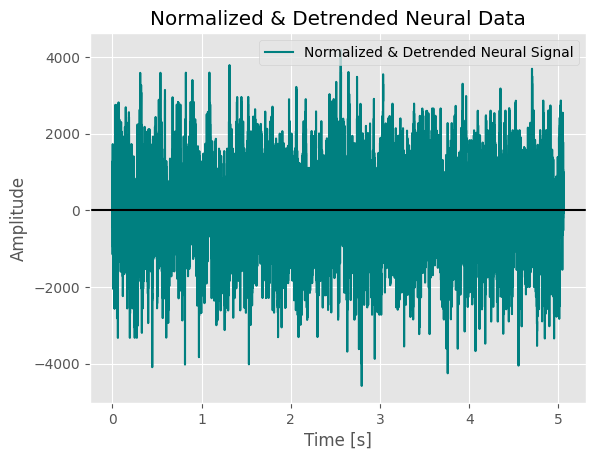

In [17]:
plt.plot(time_array, detrended_neural_data, color="teal")
plt.title("Normalized & Detrended Neural Data")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend(["Normalized & Detrended Neural Signal"])
plt.axhline(y=0, color="black")
plt.show()

### Band-Pass Filter


In [18]:
nyq = sample_rate // 2
low_cutoff_freq = 500
high_cutoff_freq = 5000
low = low_cutoff_freq / nyq
high = high_cutoff_freq / nyq
order = 4
numerator, denominator = butter(order, [low, high], btype="band")

filtered_data_bandpass = np.int16(
    lfilter(numerator, denominator, detrended_neural_data)
)

### Detecting Neural Spikes


In [19]:
spike_train_time_index_list = detect_neural_spikes(time_array, filtered_data_bandpass)

## Plotting Results


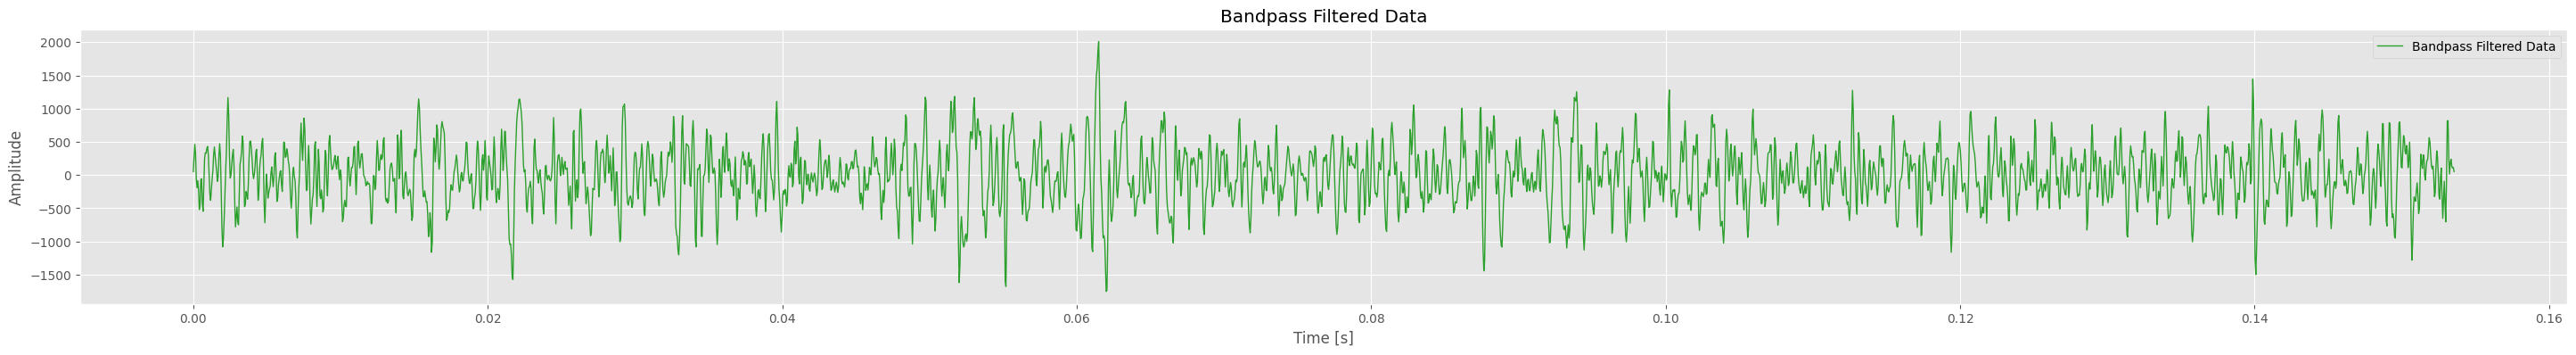

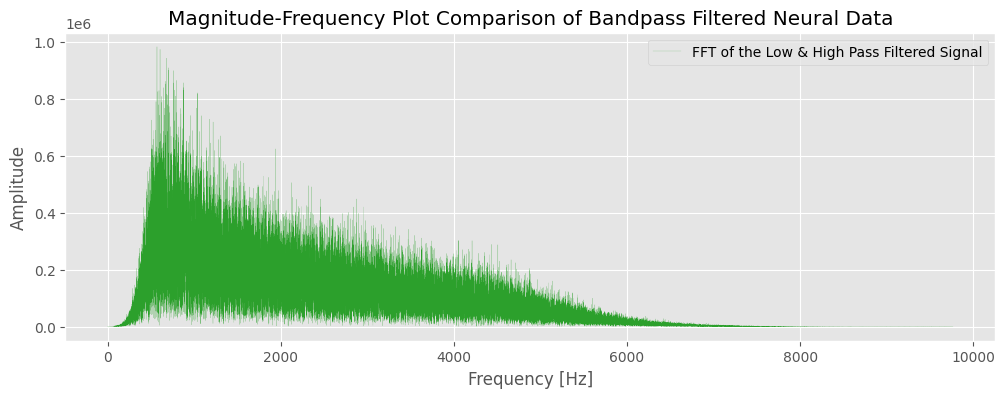

In [20]:
filtered_data_bandpass_fft = np.fft.fft(filtered_data_bandpass)
freq_bins_filtered_data_bandpass_fft = np.arange(
    0, sample_rate / 2, step=(sample_rate / len(filtered_data_bandpass_fft))
)

# Time Domain Plot
plt.figure(figsize=(36, 4))
plt.plot(
    time_array[0:3000],
    filtered_data_bandpass[0:3000],
    color=list(mcolors.TABLEAU_COLORS.keys())[2],
    linewidth=1,
    label="Bandpass Filtered Data",
)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Bandpass Filtered Data")
plt.legend()
plt.grid(True)
plt.show()

# FFT Plot
plt.figure(figsize=(12, 4))
if len(freq_bins_filtered_data_bandpass_fft) == (len(filtered_data_bandpass_fft) // 2):
    fft_slice = len(freq_bins_filtered_data_bandpass_fft)
else:
    fft_slice = len(freq_bins_filtered_data_bandpass_fft) - 1
plt.plot(
    freq_bins_filtered_data_bandpass_fft[0:fft_slice],
    np.abs(filtered_data_bandpass_fft[0 : len(filtered_data_bandpass_fft) // 2]),
    color=list(mcolors.TABLEAU_COLORS.keys())[2],
    label="FFT of the Low & High Pass Filtered Signal",
    linewidth=0.1,
)

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.title("Magnitude-Frequency Plot Comparison of Bandpass Filtered Neural Data")
plt.legend()
plt.grid(True)
plt.show()

### Identifying Potential First Spike Points


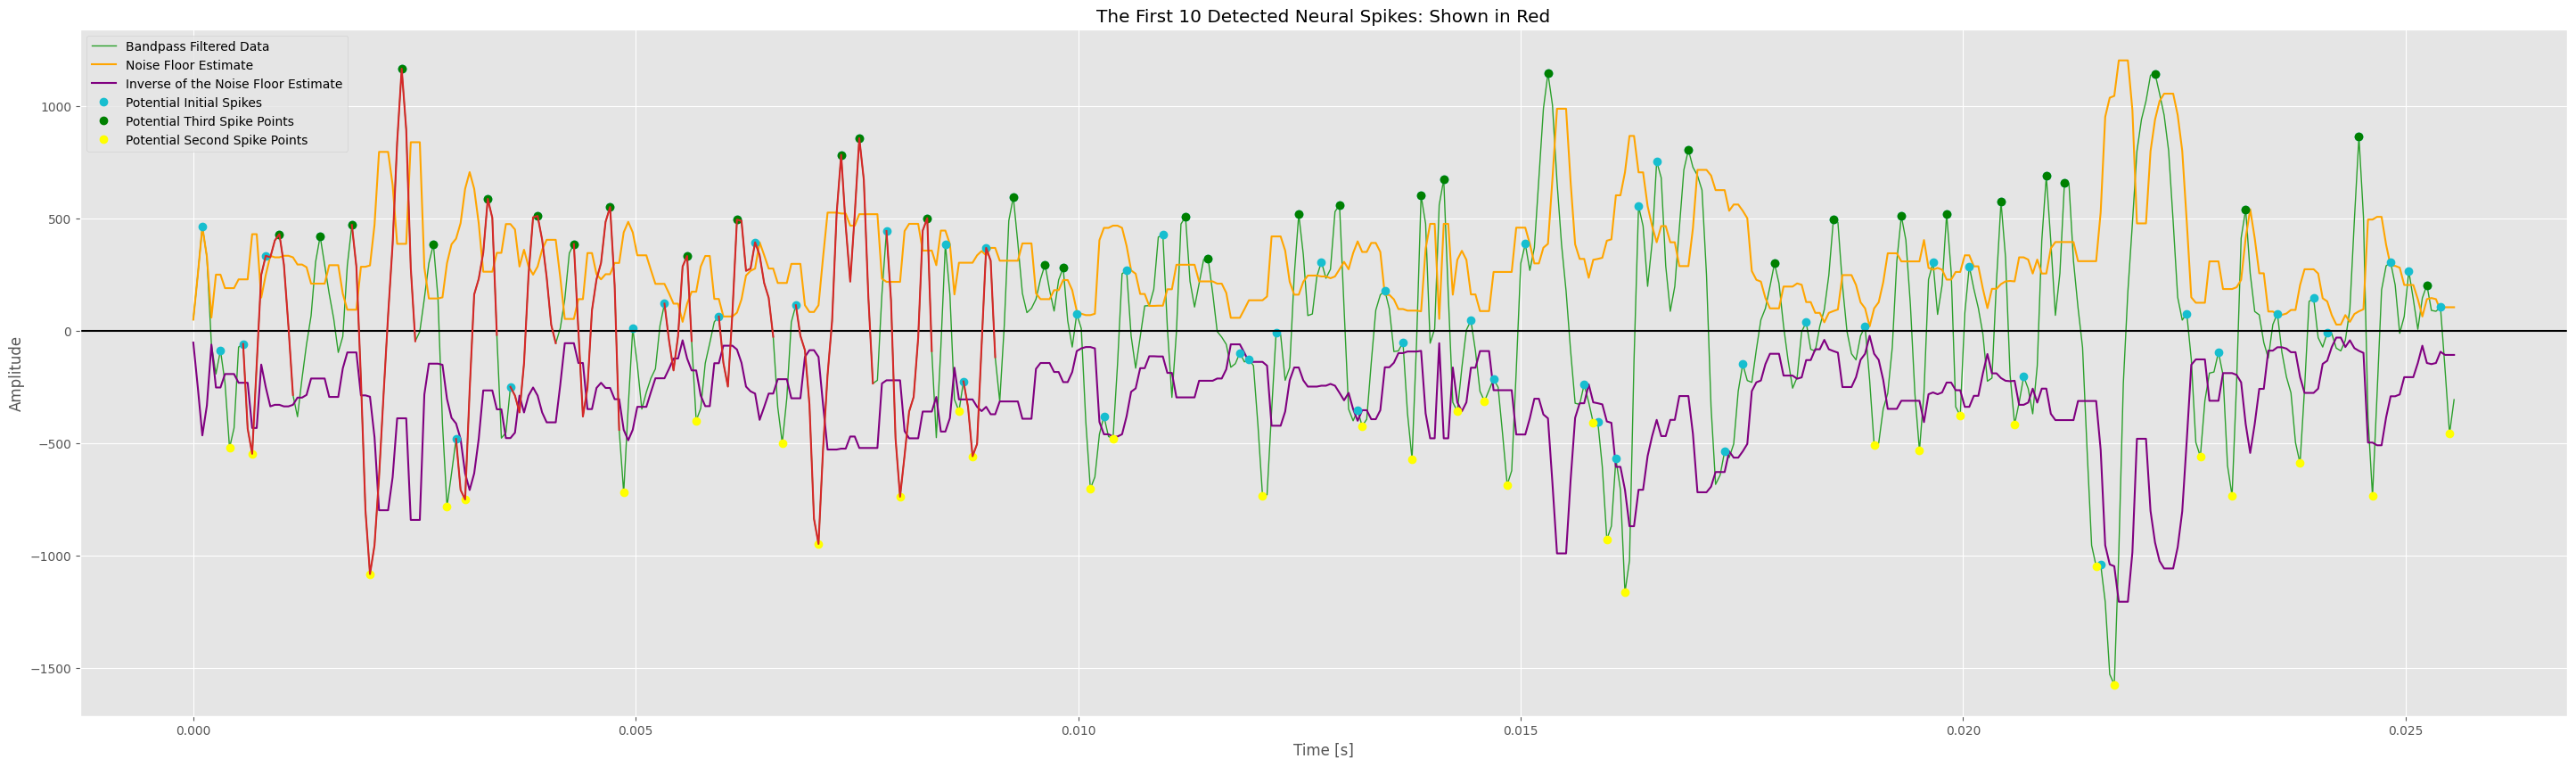

In [21]:
# Identifying Potential First Spike Points
local_maximum_list = identify_potential_initial_spikes(filtered_data_bandpass)

# Identifying Noise Floor Estimate

# Simulating Real-Time Detection of the Noise Floor & its Inverse
noise_floor_estimate = []
noise_floor_estimate_inverse = []
noise_floor_window = 5

for current_time_index, time in enumerate(time_array):
    # Estimate the noise floor
    if current_time_index < noise_floor_window:
        current_noise_floor_estimate_list = estimate_noise_floor(
            [filtered_data_bandpass[current_time_index]]
        )
    else:
        current_noise_floor_estimate_list = estimate_noise_floor(
            filtered_data_bandpass[
                current_time_index - noise_floor_window : current_time_index
            ],
            window_size=noise_floor_window,
        )
    current_noise_floor_estimate = current_noise_floor_estimate_list[0]
    noise_floor_estimate.append(current_noise_floor_estimate)

    current_noise_floor_estimate_inverse = -(current_noise_floor_estimate)
    noise_floor_estimate_inverse.append(current_noise_floor_estimate_inverse)

# Time Domain Plot
# WINDOW_SIZE = len(time_array)
PLOT_WINDOW_SIZE = 500

# Subsets
time_array_subset = time_array[0:PLOT_WINDOW_SIZE]
filtered_data_bandpass_subset = filtered_data_bandpass[0:PLOT_WINDOW_SIZE]
noise_floor_estimate_subset = noise_floor_estimate[0:PLOT_WINDOW_SIZE]
noise_floor_estimate_inverse_subset = noise_floor_estimate_inverse[0:PLOT_WINDOW_SIZE]

# Calculating Spikes
# Third Points
time_array_subset_above_noise_floor_estimate = time_array_subset[
    filtered_data_bandpass_subset > noise_floor_estimate_subset
]
filtered_data_bandpass_subset_above_noise_floor_estimate = (
    filtered_data_bandpass_subset[
        filtered_data_bandpass_subset > noise_floor_estimate_subset
    ]
)

filtered_data_bandpass_subset_above_noise_floor_estimate_local_maximum_list = (
    identify_potential_initial_spikes(
        filtered_data_bandpass_subset_above_noise_floor_estimate
    )
)

third_points = filtered_data_bandpass_subset_above_noise_floor_estimate[
    filtered_data_bandpass_subset_above_noise_floor_estimate_local_maximum_list
]
time_third_points = time_array_subset_above_noise_floor_estimate[
    filtered_data_bandpass_subset_above_noise_floor_estimate_local_maximum_list
]

# Second Points
time_array_subset_below_noise_floor_estimate_inverse = time_array_subset[
    filtered_data_bandpass_subset < noise_floor_estimate_inverse_subset
]

filtered_data_bandpass_subset_below_noise_floor_estimate_inverse = (
    filtered_data_bandpass_subset[
        filtered_data_bandpass_subset < noise_floor_estimate_inverse_subset
    ]
)
filtered_data_bandpass_subset_below_noise_floor_estimate_inverse_local_minimum_list = (
    identify_potential_initial_spikes(
        filtered_data_bandpass_subset_below_noise_floor_estimate_inverse,
        return_local_maximum=False,
    )
)

second_points = filtered_data_bandpass_subset_below_noise_floor_estimate_inverse[
    filtered_data_bandpass_subset_below_noise_floor_estimate_inverse_local_minimum_list
]
t_second_points = time_array_subset_below_noise_floor_estimate_inverse[
    filtered_data_bandpass_subset_below_noise_floor_estimate_inverse_local_minimum_list
]

plt.figure(figsize=(36, 10))
# Time Domain Signal Values
plt.plot(
    time_array[0:PLOT_WINDOW_SIZE],
    filtered_data_bandpass[0:PLOT_WINDOW_SIZE],
    color=list(mcolors.TABLEAU_COLORS.keys())[2],
    linewidth=1,
    label="Bandpass Filtered Data",
)
plt.plot(
    time_array[0:PLOT_WINDOW_SIZE],
    noise_floor_estimate[0:PLOT_WINDOW_SIZE],
    label="Noise Floor Estimate",
    color="orange",
)
plt.plot(
    time_array[0:PLOT_WINDOW_SIZE],
    noise_floor_estimate_inverse[0:PLOT_WINDOW_SIZE],
    label="Inverse of the Noise Floor Estimate",
    color="purple",
)

# Thresholded Points
plt.plot(
    time_array_subset[local_maximum_list[0:PLOT_WINDOW_SIZE]],
    filtered_data_bandpass_subset[local_maximum_list[0:PLOT_WINDOW_SIZE]],
    "o",
    color=list(mcolors.TABLEAU_COLORS.keys())[9],
    label="Potential Initial Spikes",
)

plt.plot(
    time_third_points,
    third_points,
    "o",
    color="green",
    label="Potential Third Spike Points",
)

plt.plot(
    t_second_points,
    second_points,
    "o",
    color="yellow",
    label="Potential Second Spike Points",
)

plt.axhline(y=0, color="black")

# Detected Spikes
MAX_SPIKES_TO_PLOT = 10
for SPIKE_NUMBER in range(0, MAX_SPIKES_TO_PLOT):
    plt.plot(
        time_array[spike_train_time_index_list[SPIKE_NUMBER]],
        filtered_data_bandpass[spike_train_time_index_list[SPIKE_NUMBER]],
        "-",
        color=list(mcolors.TABLEAU_COLORS.keys())[3],
    )

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("The First %i Detected Neural Spikes: Shown in Red" % MAX_SPIKES_TO_PLOT)
plt.legend()
plt.grid(True)
plt.show()

Number of Points in detected spike: 15


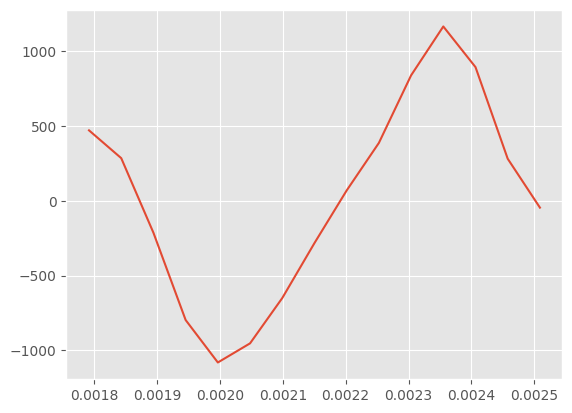

In [22]:
SPIKE_NUMBER = 1

plt.plot(
    time_array[spike_train_time_index_list[SPIKE_NUMBER]],
    filtered_data_bandpass[spike_train_time_index_list[SPIKE_NUMBER]],
)

print(f"Number of Points in detected spike: ", end="")
print(f"{len(spike_train_time_index_list[SPIKE_NUMBER])}")

In [23]:
""" 
    Algorithm:
    1. Create a third degree polynomial to fit the first detected spike.
    2. Create a line of best fit to another detected spike using a third
        degree polynomial.
    3. Compare the difference between the polynomials. This should be a
        difference in scale and shift. 
    4. Include residuals, the scale, & the shift needed to recreate the
        waveform. The number of points should be inferred to be
        equidistant. The scale and shift will differ based upon the
        first detected spike. If this information is less than the
        number of points total in the original spike, then use this as
        a means of representing the waveform. Otherwise, use the
        explicitly defined points. 
    5. Create a means of representing the encoding. Include a list of
        compressed waveforms and a list of explicitly defined points.
        Include identifiers of the length of the number of values in
        each list before the list. This order is implied knowledge when
        decoding. 
"""

' \n    Algorithm:\n    1. Create a third degree polynomial to fit the first detected spike.\n    2. Create a line of best fit to another detected spike using a third\n        degree polynomial.\n    3. Compare the difference between the polynomials. This should be a\n        difference in scale and shift. \n    4. Include residuals, the scale, & the shift needed to recreate the\n        waveform. The number of points should be inferred to be\n        equidistant. The scale and shift will differ based upon the\n        first detected spike. If this information is less than the\n        number of points total in the original spike, then use this as\n        a means of representing the waveform. Otherwise, use the\n        explicitly defined points. \n    5. Create a means of representing the encoding. Include a list of\n        compressed waveforms and a list of explicitly defined points.\n        Include identifiers of the length of the number of values in\n        each list before the

## Encoding Detected Spikes


In [24]:
encoded_data = create_encoded_data(
    sample_rate,
    len(filtered_data_bandpass),
    spike_train_time_index_list,
    filtered_data_bandpass,
)

-32761
-32748
-32723
-32695
-32668
-32646
-32617
-32600
-32586
-32572
-32554
-32529
-32504
-32490
-32468
-32444
-32424
-32400
-32345
-32325
-32311
-32302
-32291
-32277
-32244
-32212
-32191
-32167
-32158
-32138
-32116
-32089
-31974
-31957
-31944
-31861
-31832
-31807
-31794
-31778
-31751
-31707
-31697
-31669
-31637
-31608
-31546
-31521
-31510
-31494
-31465
-31426
-31378
-31359
-31326
-31281
-31269
-31259
-31245
-31237
-31213
-31136
-31113
-31083
-31069
-31052
-31021
-31004
-30980
-30971
-30945
-30914
-30889
-30866
-30846
-30836
-30812
-30782
-30767
-30754
-30739
-30717
-30685
-30675
-30655
-30581
-30546
-30510
-30488
-30457
-30436
-30335
-30273
-30251
-30235
-30215
-30191
-30163
-30134
-30107
-30061
-30045
-30023
-30009
-29994
-29959
-29930
-29910
-29890
-29875
-29847
-29835
-29811
-29780
-29733
-29673
-29652
-29626
-29613
-29576
-29534
-29509
-29472
-29417
-29391
-29301
-29288
-29276
-29227
-29208
-29185
-29160
-29144
-29114
-29081
-29060
-29037
-29007
-28994
-28981
-28950
-28908
-28893

In [25]:
encoded_data

[19531,
 98741,
 11,
 array([ -57, -434, -546, -149,  250,  335,  328,  403,  431,  296,   22,
        -284], dtype=int16),
 35,
 array([  472,   286,  -213,  -797, -1081,  -953,  -650,  -282,    70,
          388,   840,  1167,   895,   282,   -45], dtype=int16),
 58,
 array([-480, -707, -749, -264,  163,  232,  348,  588,  504,  -17],
       dtype=int16),
 70,
 array([-248, -287, -362, -143,  251,  506,  512,  406,  239,   28,  -54],
       dtype=int16),
 84,
 array([ 387,    3, -380, -253,   93,  230,  303,  486,  552,  204, -439],
       dtype=int16),
 104,
 array([ 122,  -41, -175,  -22,  287,  334,  -44], dtype=int16),
 116,
 array([  65, -141, -247,   82,  496,  490,  268,  278,  395,  338,  214,
         148,  -25], dtype=int16),
 133,
 array([ 115,  -21,  -85, -327, -835, -947, -527, -195,   45,  523,  784,
         469,  220,  520,  858,  673,  152, -233], dtype=int16),
 153,
 array([ 445,  138, -477, -737, -553, -358, -293,  -30,  447,  502,  -89],
       dtype=int16),
 170,

In [26]:
# Percent Reduction in file size
print(
    "The original file size has been reduced by %0.2f%%. "
    % ((1 - sys.getsizeof(encoded_data) / sys.getsizeof(raw_neural_data)) * 100)
)

The original file size has been reduced by 69.77%. 


# Decoding the data


In [27]:
# Extract Metadata
encoded_data
encoded_data = deque(encoded_data)
sample_rate = encoded_data.popleft()
number_of_samples = encoded_data.popleft()

# Construct the Time Array
time_endpoint = number_of_samples / sample_rate
time_array = np.arange(start=0, stop=time_endpoint, step=(1 / sample_rate))

# Create the Amplitude Array
amplitude_array = np.int16(np.zeros(len(time_array)))
counter = 0
while len(encoded_data) > 0:
    counter += 1
    amplitude_start_time_index = encoded_data.popleft()
    if amplitude_start_time_index < 0:
        print(amplitude_start_time_index)
    spike_amplitudes = encoded_data.popleft()
    if counter == 3378:
        print(counter)
    for amplitude_index, amplitude in enumerate(spike_amplitudes):
        amplitude_array[amplitude_start_time_index + amplitude_index] = amplitude

3378


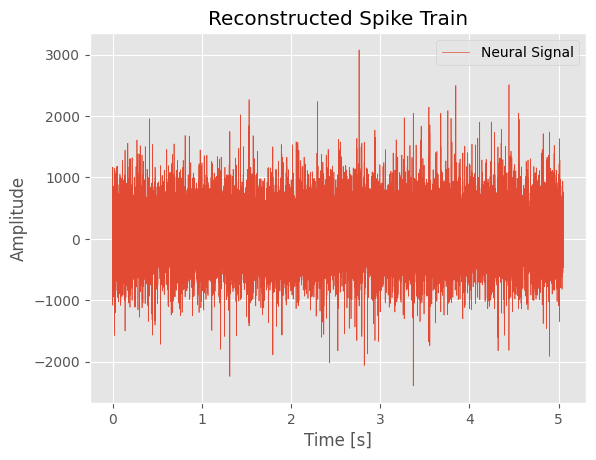

In [28]:
SCALAR = 60

PLOT_WINDOW_SHIFT = 10 * SCALAR
PLOT_WINDOW_LENGTH = 10 * SCALAR
# plt.plot(
#     time_array[PLOT_WINDOW_SHIFT : PLOT_WINDOW_SHIFT + PLOT_WINDOW_LENGTH],
#     amplitude_array[PLOT_WINDOW_SHIFT : PLOT_WINDOW_SHIFT + PLOT_WINDOW_LENGTH],
#     linewidth=0.5,
# )

plt.plot(
    time_array,
    amplitude_array,
    linewidth=0.5,
)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Reconstructed Spike Train")
plt.legend(["Neural Signal"])
plt.show()

In [29]:
ipd.Audio(amplitude_array, rate=sample_rate)